In [5]:

import numpy as np
import pandas as pd

# plotting
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})

import pymc3 as pm
import arviz as az

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [25]:

SEED = 123

n_samples = 1_000
m = 1
c = 0
N = 100

truncation_bounds = [-1.5, 1.5]

sample_options = {
    "tune": 1_000,
    "draws": n_samples,
    "chains": 1,
    "cores": 1,
    #"nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

np.random.seed(SEED)

In [7]:

def make_data():
    x = np.random.randn(N)
    ϵ = np.random.randn(N) * 0.5
    y = m * x + c + ϵ
    return (x, y)


x, y = make_data()

In [8]:
def truncate_y(x, y, truncation_bounds):
    trunc = (y >= truncation_bounds[0]) & (y <= truncation_bounds[1])
    return (x[trunc], y[trunc])


xt, yt = truncate_y(x, y, truncation_bounds)

In [11]:
def plot_true(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    x = np.array([-3, 3])
    ax.plot(x, m * x + c, "r", lw=3, label="True")
    ax.legend()

[Text(0.5, 1.0, 'Truncated data'), Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

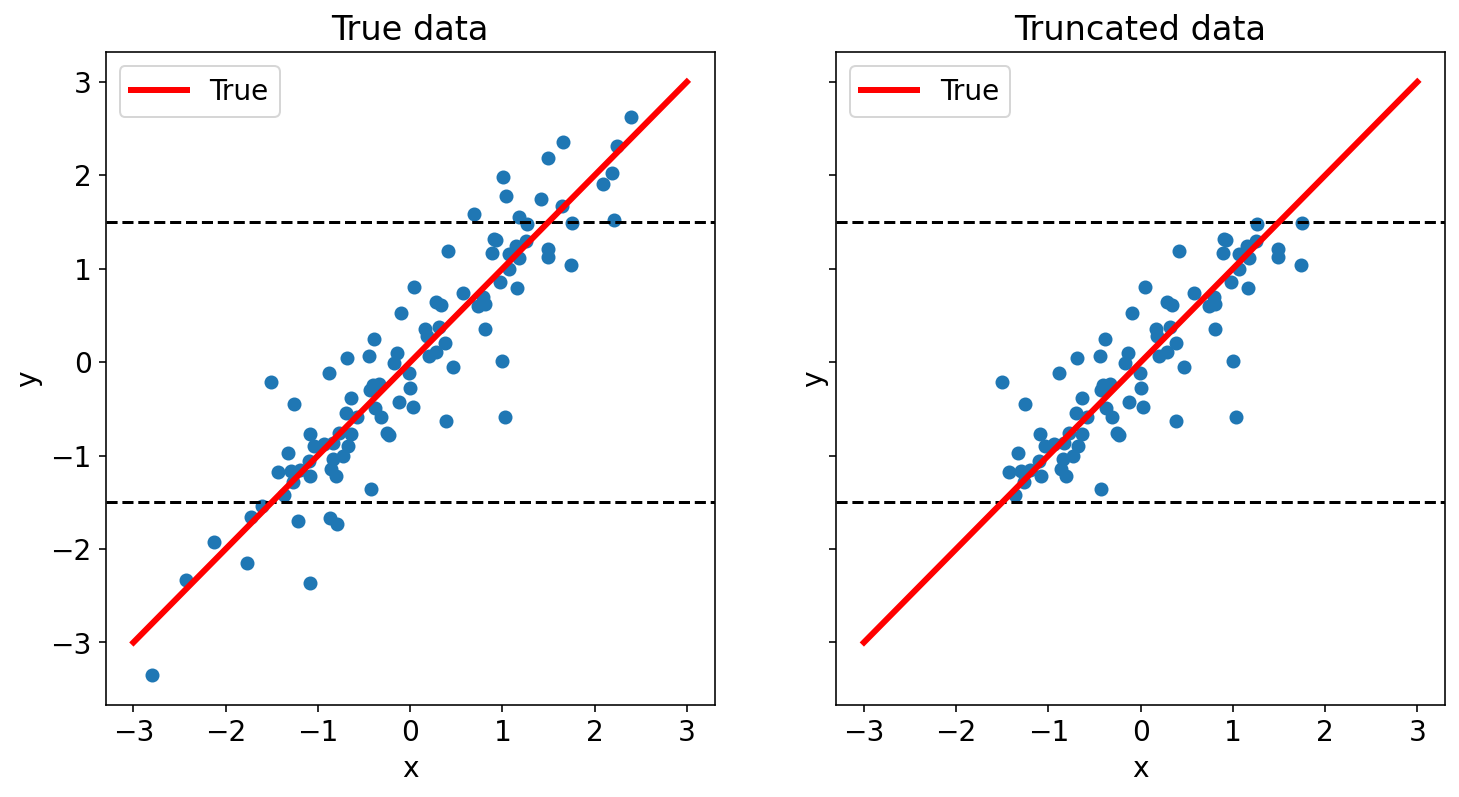

In [12]:
def plot_data(x, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    ax.scatter(x, y)
    for bound in truncation_bounds:
        ax.axhline(y=bound, c="k", ls="--")
    ax.set(title="True data", xlabel="x", ylabel="y")
    return ax


fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

_ = plot_data(x, y, ax=ax[0])
plot_true(ax=ax[0])
ax[0].set(title="True data", xlabel="x", ylabel="y")

_ = plot_data(xt, yt, ax=ax[1])
plot_true(ax=ax[1])
ax[1].set(title="Truncated data", xlabel="x", ylabel="y")

In [22]:

def regression(x, y):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=m * x + c, sd=σ, observed=y)

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [23]:
model, trace = regression(x, y)
_, trace_t = regression(xt, yt)

<ipython-input-22-fc6ff82757a4>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sample_options)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
D:\Conda\envs\qmra\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
D:\Conda\envs\qmra\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
D:\Conda\envs\qmra\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [σ, c, m]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 196 seconds.
<ipython-input-22-fc6ff82757a4>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sample_options)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
D:\Conda\envs\qmra\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
D:\Conda\envs\qmra\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
D:\Conda\envs\qmra\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 177 seconds.


<ipython-input-24-81e45c63140c>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, var_names=["m", "c", "σ"])
D:\Conda\envs\qmra\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

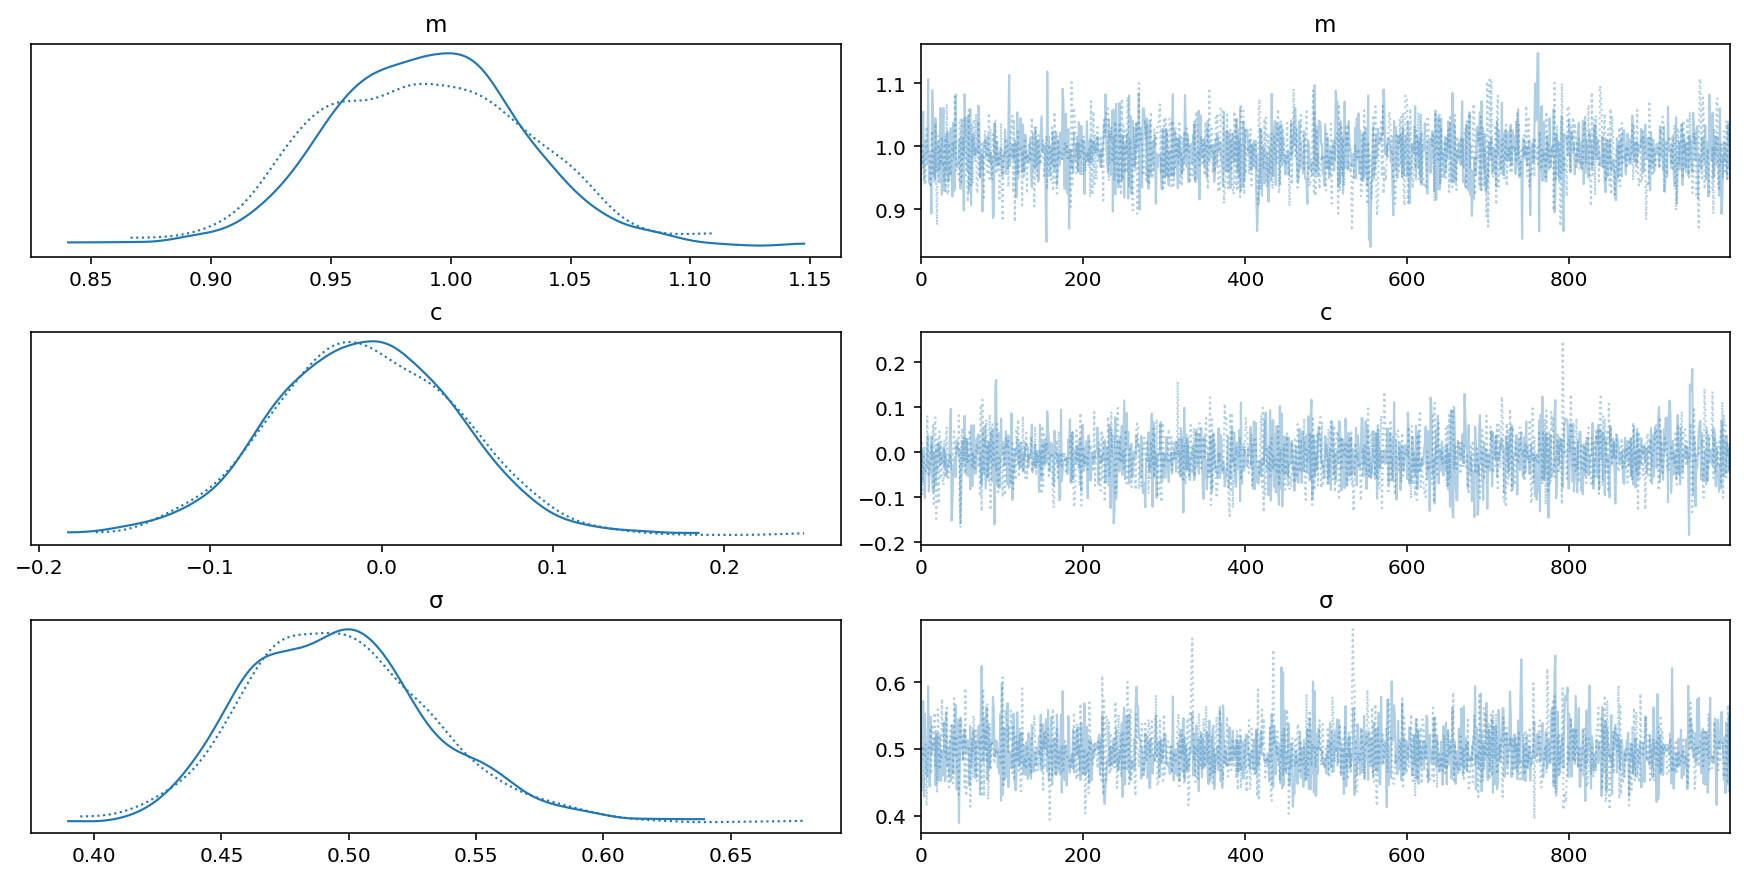

In [24]:
pm.traceplot(trace, var_names=["m", "c", "σ"])

In [28]:
def truncated_regression(x, y):
    """Sample from a truncated linear regression model"""

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)

        #BoundedNormal = pm.Bound(
        #    pm.Normal, lower=truncation_bounds[0], upper=truncation_bounds[1]
        #)
        #y_likelihood = BoundedNormal("y_likelihood", mu=m * x + c, sd=σ, observed=y)
        
         #THIS IS WHAT I WAS DOING BEFORE...
        y_likelihood = pm.TruncatedNormal(
             "y_likelihood",
             mu=m * x + c,
             sd=σ,
             observed=y,
             lower=truncation_bounds[0],
             upper=truncation_bounds[1],
         )

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [ ]:
_, trace_truncated = truncated_regression(xt, yt)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
<ipython-input-28-8305dfd843c0>:25: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sample_options)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
D:\Conda\envs\qmra\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
D:\Conda\envs\qmra\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
D:\Conda\envs\qmra\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  var

D:\Conda\envs\qmra\lib\site-packages\theano\scalar\basic.py:3023: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
D:\Conda\envs\qmra\lib\site-packages\theano\scalar\basic.py:1955: RuntimeWarning: divide by zero encountered in true_divide
  return x / y
D:\Conda\envs\qmra\lib\site-packages\theano\scalar\basic.py:1955: RuntimeWarning: invalid value encountered in true_divide
  return x / y
D:\Conda\envs\qmra\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
